# Movielens SBR(Session Based Recommendation)

1) 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

2) Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

3) Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [471]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [472]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [473]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::',  engine='python', encoding = "ISO-8859-1")
    data.columns = ['SessionId', 'MovieId', 'Rating', 'Time']
    return data


In [474]:

data = load_data(train_path, None)
# data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,MovieId,Rating,Time
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268
...,...,...,...,...
1000203,6040,1091,1,956716541
1000204,6040,1094,5,956704887
1000205,6040,562,5,956704746
1000206,6040,1096,4,956715648


### Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [475]:
data['SessionId'].nunique(), data['MovieId'].nunique()

(6040, 3706)

### Session length(Movie clicks per ID )

In [476]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        52
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

### statistics of MOVIE_CLICKS/ID

In [477]:
print(f'median click number : {session_length.median()}')
print(f'mean click number : {session_length.mean()}')

median click number : 96.0
mean click number : 165.5973509933775


### MEAN >> Median -> left-skewed data (or some outliers)

In [478]:
session_length.min(), session_length.max()

(20, 2314)

In [479]:
session_length.quantile(0.95)

556.0

In [480]:
# drop_sessionid = session_length[session_length>556].index
# mask = data['SessionId'].isin(list(drop_sessionid))
# data

99% of session lengths are under 1000

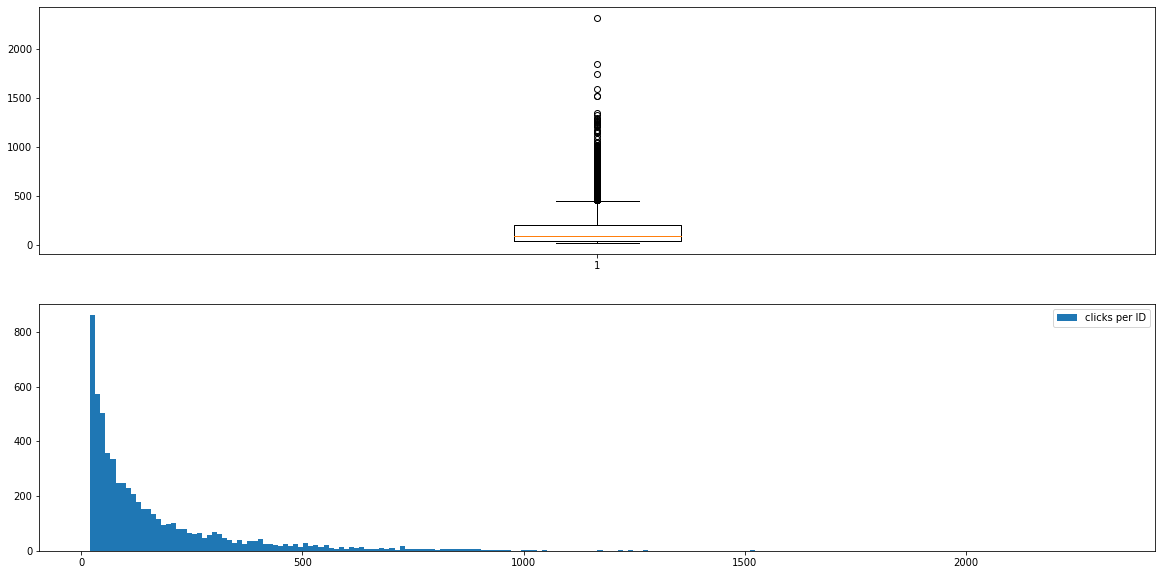

In [481]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.boxplot(session_length.values)
plt.subplot(2,1,2)
plt.hist(session_length.values, bins=200,label='clicks per ID')
plt.legend()
plt.show()

### Session time 

In [482]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)
print(f'data of (about) {(latest-oldest)//(24*60*60)} days.' )

956703932
1046454590
data of (about) 1038 days.


### Let me use the recent 1 year(365 days) data.
and if the result is not good, I will change the span.

In [483]:
# 날짜에서 sec로 변환
def day_to_sec(days):
    return days*24*60*60

month_ago = latest - day_to_sec(365)
data = data[data['Time']>month_ago]
data

,SessionId,MovieId,Rating,Time
5024,36,3359,5,1015905485
5033,36,581,4,1015905127
5059,36,1191,4,1015905249
5061,36,1266,5,1040545109
5068,36,2713,1,1040544662
...,...,...,...,...
992774,5996,542,3,1020111524
992776,5996,1079,5,1020096629
992782,5996,552,4,1020110044
992783,5996,1086,5,1020096471


In [484]:
session_length[session_length.values ==1]

Series([], dtype: int64)

### There's no session(id) of which the value is 1.

### Split the data by
- training set : 11 months
- validation set : 15 days
- test set : 15 days
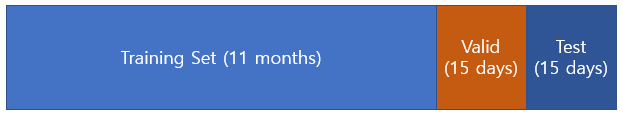

In [485]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - day_to_sec(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - day_to_sec(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['MovieId'].isin(before_date['MovieId'])]
    return before_date, after_date

In [486]:
tr, test = split_by_date(data, n_days=15)
tr, val = split_by_date(tr, n_days=15)

In [487]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["MovieId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [488]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 13986
	 Sessions: 395
	 Items: 2616
	 First Time : 1014923199
	 Last Time : 1043809240

* valid Set Stats Info
	 Events: 2226
	 Sessions: 35
	 Items: 1221
	 First Time : 1014973332
	 Last Time : 1045154214

* test Set Stats Info
	 Events: 5113
	 Sessions: 68
	 Items: 1999
	 First Time : 1014955410
	 Last Time : 1046454590



Since it is **User Id** rather than Real Session id, even 'first time' in test/validation set starts from the past. Maybe it would be rather better for its **widespread distribution**, though being different from original intention.

In [489]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['MovieId'].unique())}

def indexing(df, id2idx):
    df['movie_idx'] = df['MovieId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [490]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 
학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [491]:
class SessionDataset : 
    
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique()) #indexing to SessionId
        
    def get_click_offsets(self):
        ##Return the indexes of the first click of each session IDs,
        offsets = np.zeros(self.df['SessionId'].nunique()+1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets
        

In [492]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,MovieId,Rating,Time,movie_idx
5024,36,3359,5,1015905485,0
5033,36,581,4,1015905127,1
5059,36,1191,4,1015905249,2
5061,36,1266,5,1040545109,3
5068,36,2713,1,1040544662,4
5072,36,1912,5,1015904924,5
5075,36,595,4,1040545109,6
5103,36,247,4,1040545068,7
5108,36,1283,4,1015962403,8
5112,36,2662,3,1015904924,9


In [493]:
tr_dataset.click_offsets

array([    0,    34,   154,   161,   261,   277,   282,   284,   285,
         352,   353,   355,   380,   386,   405,   422,   443,   498,
         571,   584,   676,   725,   769,   775,   784,   804,   813,
         825,   831,   835,   876,   908,   922,   928,   951,  1068,
        1069,  1075,  1092,  1112,  1138,  1141,  1192,  1200,  1230,
        1234,  1236,  1392,  1398,  1404,  1450,  1461,  1660,  1672,
        1715,  1719,  1728,  1729,  1731,  1733,  1749,  1752,  1795,
        1796,  1812,  1813,  1818,  1829,  1838,  1839,  1900,  2029,
        2086,  2100,  2114,  2120,  2282,  2293,  2296,  2301,  2874,
        2896,  2929,  2943,  2944,  2947,  2973,  2976,  2984,  2997,
        3005,  3008,  3052,  3124,  3128,  3137,  3163,  3199,  3300,
        3368,  3406,  3457,  3470,  3610,  3613,  3630,  3631,  3651,
        3666,  3735,  3737,  3753,  3755,  3789,  3878,  3911,  3925,
        3930,  4187,  4217,  4228,  4307,  4313,  4387,  4402,  4403,
        4455,  4639,

In [494]:
len(tr_dataset.click_offsets)

396

In [495]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [496]:
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=20):
        self.dataset = dataset
        self.batch_size = batch_size
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """
        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['movie_idx'].values[start + i]
                target = self.dataset.df['movie_idx'].values[start + i + 1]
                yield inp, target, mask
            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
            
    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        #print(first_iters)
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [497]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,MovieId,Rating,Time,movie_idx
5024,36,3359,5,1015905485,0
5033,36,581,4,1015905127,1
5059,36,1191,4,1015905249,2
5061,36,1266,5,1040545109,3
5068,36,2713,1,1040544662,4
5072,36,1912,5,1015904924,5
5075,36,595,4,1040545109,6
5103,36,247,4,1040545068,7
5108,36,1283,4,1015962403,8
5112,36,2662,3,1015904924,9


In [498]:
iter_ex = iter(tr_data_loader)

In [499]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input movie Idx are : {inputs}')
print(f'Label movie Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input movie Idx are : [  0  34 149 155]
Label movie Idx are :       [  1  35 150 156]
Previous Masked Input Idx are []


### Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [500]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [501]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [502]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [503]:
class Args :
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
args = Args(tr,val, test, batch_size=4, hsz=50, drop_rate=0.1, lr=0.001,epochs=3, k=20)
    

In [504]:
model = create_model(args)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(4, 1, 2616)]            0         
_________________________________________________________________
GRU (GRU)                    [(4, 50), (4, 50)]        400200    
_________________________________________________________________
dropout_30 (Dropout)         (4, 50)                   0         
_________________________________________________________________
dense_30 (Dense)             (4, 2616)                 133416    
Total params: 533,616
Trainable params: 533,616
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [505]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [506]:
train_model(model, args)

Train:   0%|          | 0/3397 [00:00<?, ?it/s, accuracy=0, train_loss=7.19]   

	 - Recall@20 epoch 1: 0.055846
	 - MRR@20    epoch 1: 0.009824



Train:   0%|          | 0/3397 [00:00<?, ?it/s, accuracy=0, train_loss=7.03]

	 - Recall@20 epoch 2: 0.080898
	 - MRR@20    epoch 2: 0.017973



Evaluation:  88%|████████▊ | 479/547 [00:24<00:03, 19.50it/s]

	 - Recall@20 epoch 3: 0.119520
	 - MRR@20    epoch 3: 0.030687



### Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [507]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  94%|█████████▎| 1182/1261 [01:01<00:04, 19.12it/s]

	 - Recall@20: 0.076142
	 - MRR@20: 0.019956



## 회고

 mini batch와 기타 코드에 대한 면밀한 이해가 필요해 보인다.